# Image Classification with Malaria Dataset: Training a CNN and Converting to TensorFlow Lite
Name : Diandra R. A. Damanik

Dicoding Username : diandra_regita

Email : diandraregita14@gmail.com

In [1]:
!pip install kaggle

### Import necessary libraries

In [65]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
import string
import zipfile

from keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 657M/675M [00:10<00:00, 99.8MB/s]
100% 675M/675M [00:10<00:00, 68.4MB/s]


Unzip the file to a specific destination

In [5]:
# Unzip the file to a specific destination
with zipfile.ZipFile('cell-images-for-detecting-malaria.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

### Check image resolutions

In [6]:
def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size

def check_image_resolutions(folder_path):
    resolutions = set()

    # Iterate through subfolders
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png')):
                image_path = os.path.join(subdir, file)
                resolution = get_image_resolution(image_path)
                resolutions.add(resolution)

    # Check if resolutions are different
    if len(resolutions) > 1:
        print("Resolutions are different:")
        for res in resolutions:
            print(res)
        return False

    print("Resolutions are consistent:", resolutions.pop())
    return True

In [17]:
shutil.rmtree('cell_images/cell_images')

In [ ]:
# Specify the path to the folder containing subfolders with images
base_path = 'cell_images'

# Check image resolutions
result = check_image_resolutions(base_path)

Resolutions are different:
(166, 181)
(124, 184)
(130, 115)
(88, 118)
(139, 163)
(199, 214)
(205, 145)
(97, 166)
(163, 148)
(121, 151)
(196, 181)
(94, 133)
(154, 184)
(193, 175)
(157, 109)
(127, 166)
(187, 217)
(190, 142)
(109, 154)
(127, 202)
(148, 145)
(160, 199)
(142, 187)
(181, 178)
(145, 112)
(238, 160)
(103, 115)
(160, 91)
(118, 94)
(178, 145)
(136, 148)
(142, 79)
(100, 82)
(151, 127)
(130, 190)
(169, 181)
(175, 112)
(133, 115)
(226, 163)
(91, 118)
(163, 223)
(202, 214)
(106, 97)
(166, 148)
(226, 199)
(124, 151)
(130, 82)
(88, 85)
(139, 130)
(97, 133)
(157, 184)
(163, 115)
(121, 118)
(172, 163)
(196, 148)
(94, 100)
(154, 151)
(172, 199)
(112, 154)
(94, 136)
(127, 133)
(187, 184)
(112, 190)
(145, 187)
(109, 121)
(127, 169)
(148, 112)
(145, 223)
(184, 151)
(142, 154)
(181, 145)
(142, 190)
(103, 82)
(175, 187)
(115, 172)
(136, 115)
(208, 220)
(151, 94)
(58, 52)
(130, 157)
(169, 148)
(133, 82)
(205, 187)
(130, 193)
(91, 85)
(241, 289)
(202, 181)
(205, 223)
(166, 115)
(124, 118)
(139,

### Create Train-Validation Split

In [18]:
base_path = 'cell_images'

# Create lists to hold file paths
image_paths = []
labels = []

# Populate image_paths and labels
for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image_paths.append(image_path)
            labels.append(label)

# Reserve a specific percentage of images for deployment testing
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.0005, random_state=42, stratify=labels
)

# Split the remaining data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, random_state=42, stratify=train_val_labels
)

### Create Directories for Train and Validation Data

In [19]:
train_dir = 'train_data'
val_dir = 'val_data'
test_dir = 'test_data'

for label in set(labels):
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

### Move Images to Respective Directories

In [20]:
def move_images(image_paths, labels, destination_dir):
    for image_path, label in zip(image_paths, labels):
        destination_path = os.path.join(destination_dir, label, os.path.basename(image_path))
        shutil.copy(image_path, destination_path)

move_images(train_paths, train_labels, train_dir)
move_images(val_paths, val_labels, val_dir)
move_images(test_paths, test_labels, test_dir)

In [21]:
def get_class_lengths(directory):
    class_lengths = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_lengths[class_name] = num_images
    return class_lengths

# Replace these with your actual directories
train_dir = 'train_data'
val_dir = 'val_data'
test_dir = 'test_data'

# Get class lengths for each directory
train_class_lengths = get_class_lengths(train_dir)
val_class_lengths = get_class_lengths(val_dir)
test_class_lengths = get_class_lengths(test_dir)

# Print the results
print("Train Class Lengths:", train_class_lengths)
print("Validation Class Lengths:", val_class_lengths)
print("Test Class Lengths:", test_class_lengths)

Train Class Lengths: {'Uninfected': 11018, 'Parasitized': 11018}
Validation Class Lengths: {'Uninfected': 2755, 'Parasitized': 2755}
Test Class Lengths: {'Uninfected': 7, 'Parasitized': 7}


### Parasitized Cells

In [55]:
output_dir = '/content/output_images'
os.makedirs(output_dir, exist_ok=True)
image_directory = 'test_data/Parasitized'
image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory)]
title = 'Parasitized Cells'

# Blank canvas for the collage
collage_width = 600
collage_height = 400
collage = Image.new('RGB', (collage_width, collage_height), 'white')

# Create a drawing object
draw = ImageDraw.Draw(collage)

# Draw the title at the top
title_position = (collage_width // 2 - draw.textbbox((0, 0), title)[0] // 2, 10)
draw.text(title_position, title, fill='black')

# Loop through the image paths and paste them onto the collage
image_size = (collage_width // 3, collage_height // 2)
for i, path in enumerate(image_paths):
    img = Image.open(path)
    img = img.resize(image_size, Image.LANCZOS)
    position = (i % 3 * image_size[0], i // 3 * image_size[1] + 40)  # Add 40 for title space
    collage.paste(img, position)

# Save the collage to the output directory
output_path = os.path.join(output_dir, 'Parasitized.jpg')
collage.save(output_path)

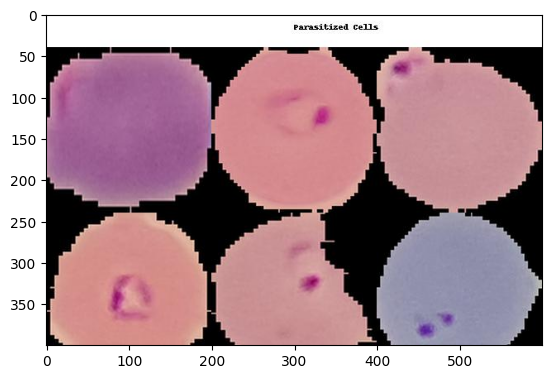

In [58]:
# Display the collage
collage = plt.imread(output_path)
plt.imshow(collage)

### Uninfected Cells

In [60]:
image_directory = 'test_data/Uninfected'
image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory)]
title = 'Uninfected Cells'

# Create a drawing object
collage = Image.new('RGB', (collage_width, collage_height), 'white')
draw = ImageDraw.Draw(collage)

# Draw the title at the top
title_position = (collage_width // 2 - draw.textbbox((0, 0), title)[0] // 2, 10)
draw.text(title_position, title, fill='black')

# Loop through the image paths and paste them onto the collage
image_size = (collage_width // 3, collage_height // 2)
for i, path in enumerate(image_paths):
    img = Image.open(path)
    img = img.resize(image_size, Image.LANCZOS)
    position = (i % 3 * image_size[0], i // 3 * image_size[1] + 40)  # Add 40 for title space
    collage.paste(img, position)

# Save the collage to the output directory
output_path = os.path.join(output_dir, 'Uninfected.jpg')
collage.save(output_path)

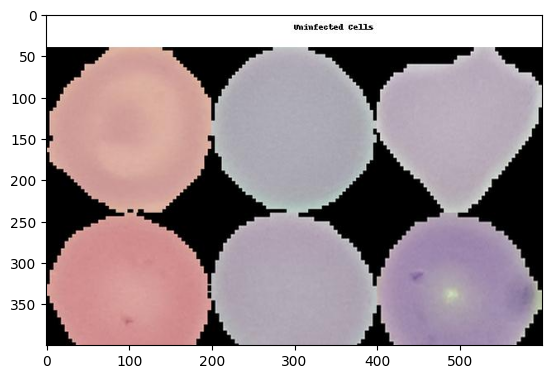

In [61]:
# Display the collage
collage = plt.imread(output_path)
plt.imshow(collage)

In [22]:
# Define image dimensions and batch size
img_width, img_height = 32, 32
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 22036 images belonging to 2 classes.
Found 5508 images belonging to 2 classes.


### Defining the CNN model architecture

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [24]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1)

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
688/688 [==============================] - 54s 70ms/step - loss: 0.4209 - accuracy: 0.7911 - val_loss: 0.1890 - val_accuracy: 0.9312
Epoch 2/50
688/688 [==============================] - 40s 58ms/step - loss: 0.2052 - accuracy: 0.9275 - val_loss: 0.1539 - val_accuracy: 0.9488
Epoch 3/50
688/688 [==============================] - 44s 63ms/step - loss: 0.1801 - accuracy: 0.9391 - val_loss: 0.1551 - val_accuracy: 0.9486
Epoch 4/50
688/688 [==============================] - 39s 56ms/step - loss: 0.1644 - accuracy: 0.9449 - val_loss: 0.1569 - val_accuracy: 0.9446
Epoch 5/50
688/688 [==============================] - 39s 57ms/step - loss: 0.1559 - accuracy: 0.9492 - val_loss: 0.1416 - val_accuracy: 0.9504
Epoch 6/50
688/688 [==============================] - 39s 57ms/step - loss: 0.1541 - accuracy: 0.9486 - val_loss: 0.1365 - val_accuracy: 0.9548
Epoch 7/50
688/688 [==============================] - 48s 70ms/step - loss: 0.1485 - accuracy: 0.9507 - val_loss: 0.1427 - val_accuracy:

### Model Evaluation and Visualization

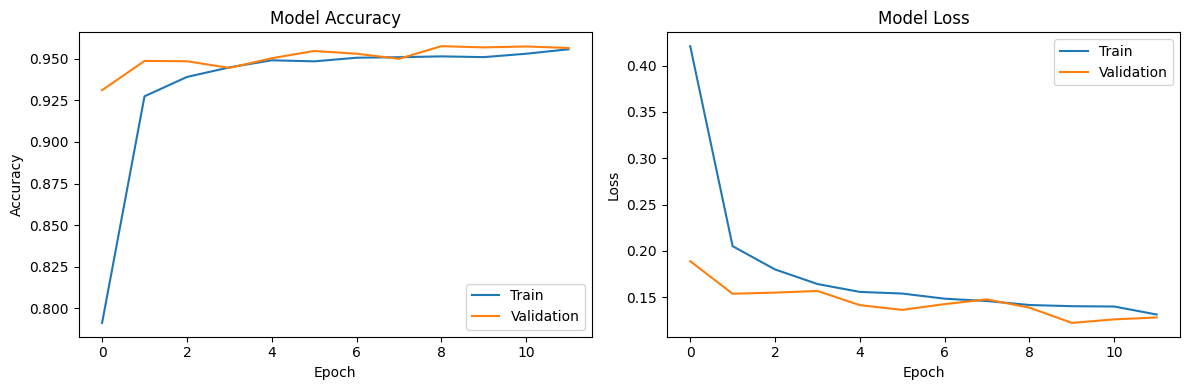

In [26]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Convert the Keras model to TF-Lite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF-Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Print a message indicating that the model has been saved
print("TF-Lite model has been successfully saved to 'model.tflite'")

TF-Lite model has been successfully saved to 'model.tflite'


### Test a Cell Image

In [29]:
# Load an image from file
image_path = 'test_data/Parasitized/C116P77ThinF_IMG_20150930_171448_cell_117.png'
img = image.load_img(image_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# train_generator.class_indices is a dictionary mapping class names to indices
class_indices = train_generator.class_indices

# Get the class label with the highest probability
predicted_class = max(class_indices, key=lambda k: predictions[0][class_indices[k]])

# Get the probability of the predicted class
predicted_probability = predictions[0][class_indices[predicted_class]]

print(f"Predicted class: {predicted_class}")
print(f"Probability: {predicted_probability:.2f}")

1/1 [==============================] - 0s 26ms/step
Predicted class: Parasitized
Probability: 1.00


In [64]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to an HDF5 file
model.save_weights("model_weights.h5")

# After saving, you can load the model in another script or in Streamlit
# Load the model architecture from the JSON file
json_file = open("model_architecture.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [63]:
# Load an image from file
image_path = 'test_data/Uninfected/C133P94ThinF_IMG_20151004_155144_cell_37.png'
img = image.load_img(image_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)

# train_generator.class_indices is a dictionary mapping class names to indices
class_indices = train_generator.class_indices

# Get the class label with the highest probability
predicted_class = max(class_indices, key=lambda k: predictions[0][class_indices[k]])

# Get the probability of the predicted class
predicted_probability = predictions[0][class_indices[predicted_class]]

print(f"Predicted class: {predicted_class}")
print(f"Probability: {predicted_probability:.2f}")

1/1 [==============================] - 0s 133ms/step
Predicted class: Uninfected
Probability: 1.00


In [66]:
!zip -r /content/file.zip /content/test_data

  adding: content/test_data/ (stored 0%)
  adding: content/test_data/Uninfected/ (stored 0%)
  adding: content/test_data/Uninfected/C63P24N_ThinF_IMG_20150818_144456_cell_100.png (stored 0%)
  adding: content/test_data/Uninfected/C232ThinF_IMG_20151112_154211_cell_150.png (stored 0%)
  adding: content/test_data/Uninfected/C239ThinF_IMG_20151127_113150_cell_71.png (stored 0%)
  adding: content/test_data/Uninfected/C133P94ThinF_IMG_20151004_155144_cell_37.png (stored 0%)
  adding: content/test_data/Uninfected/C225ThinF_IMG_20151112_113836_cell_163.png (stored 0%)
  adding: content/test_data/Uninfected/C173P134NThinF_IMG_20151130_125408_cell_93.png (stored 0%)
  adding: content/test_data/Uninfected/C3thin_original_IMG_20150608_163047_cell_36.png (stored 0%)
  adding: content/test_data/Parasitized/ (stored 0%)
  adding: content/test_data/Parasitized/C116P77ThinF_IMG_20150930_171448_cell_117.png (stored 0%)
  adding: content/test_data/Parasitized/C118P79ThinF_IMG_20151002_110609_cell_20.png

In [67]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
train_generator.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [70]:
model.save('model.h5')